In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import random
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, generate_pixel_columns
from IPython.display import display, Image as IPImage

In [29]:
files = get_dataset_files()
files = random.choices(files, k=100)
# files = ['../dataset/bat.ndjson', '../dataset/snowman.ndjson', '../dataset/spider.ndjson', '../dataset/tshirt.ndjson', '../dataset/binoculars.ndjson', '../dataset/eyeglasses.ndjson', '../dataset/cow.ndjson', '../dataset/dog.ndjson', '../dataset/guitar.ndjson', '../dataset/house.ndjson']
data = [extract_random_entries(file, 10000, recognized=True) for file in files]
flat_data = [item for sublist in data for item in sublist]
df = pd.DataFrame.from_dict(flat_data, orient='columns')
print(f'Loaded {len(df)} entries from {files}')

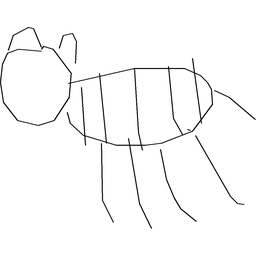

In [19]:
img = random.choice(flat_data)['drawing']
display(IPImage(render_single(img)))

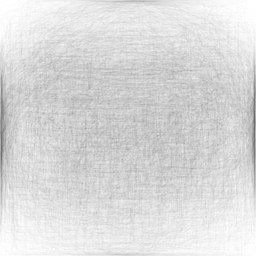

In [4]:
imgs = df.sample(1000)['drawing']
display(IPImage(render_multiple(imgs)))

In [21]:
df2 = df.sample(len(df))
train_amt = int(len(df2) * .80)

train = df2[:train_amt]
test = df2[train_amt:]

train = train.reset_index()
test = test.reset_index()

train_processed = generate_pixel_columns(train, resolution=28, invert_color=True).drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])
test_processed = generate_pixel_columns(test, resolution=28, invert_color=True)
print(f'Train: {len(train_processed)} entries, test: {len(test_processed)} entries.')

Train: 80000 entries, test: 20000 entries.


In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.decomposition import PCA
import time
import joblib

y = train_processed['word']
X = train_processed.drop(columns=['word'])

pca = PCA(.95)
pca.fit(X)

X = pca.transform(X)
print(f'Keeping {pca.n_components_} features')

#classifier = LinearSVC(random_state=0, max_iter=100000, dual=False)
classifier = NuSVC(nu=.1, max_iter=10000)
model = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
filename = '../model' + str(int(time.time()))
filedata = joblib.dump(model, filename)

Keeping 1 features


/home/chris/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/chris/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/chris/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/chris/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/chris/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver term

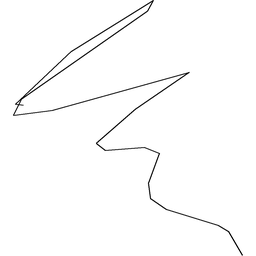

squiggle
squiggle == squiggle ? True


In [26]:
sample = test_processed.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])

sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(prediction[0])
print(f"{sample['word'].iloc[0]} == {prediction[0]} ? {sample['word'].iloc[0] == prediction[0]}")

In [28]:
test = pca.transform(test_processed.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']))
prediction = model.predict(test)

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(test_processed['word'].values.tolist(), prediction)
print(f"Accuracy score: {acc_score}")

Accuracy score: 0.9721
